## Connect to Google Colab

To train the network on a GPU, Google Colab will be used. To connect to Google Colab successfully, adjust `gdrive_path` so that it represents the root folder of the repository. In case you don't want to use Google Colab you can skip this cell.

In [1]:
from google.colab import drive
import os

# set path to project folder
gdrive_path='/content/gdrive/MyDrive/7-programming/music_recognition/'

# mount Google Drive
drive.mount('/content/gdrive', force_remount=True)

# navigate to Google Drive folder
os.chdir(gdrive_path)

# check that we are in the right folder
print(sorted(os.listdir()))

Mounted at /content/gdrive
['.git', '.gitignore', 'README.md', 'data', 'data_loader.ipynb', 'networks', 'utils']


## Manage Imports

Throughout the repository, we will use a wide range of external packages. If you use Google Colab, these packages need to be installed using `pip` every time you restart the kernel. If you don't use Google Colab, you can create a virtual environment to manage packages and versions. In this case, you only need to install these packages with `pip` once.

In [2]:
import torch
from data.primus_dataset import PrimusDataset, split_data, visualize_sample

# set up default cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load Data



Next, we will load the Primus dataset that will be used throughout this notebook. The dataset was published as part of the following publication:

```
@inproceedings{calvo2018camera,
  title={Camera-PrIMuS: Neural End-to-End Optical Music Recognition on Realistic Monophonic Scores.},
  author={Calvo-Zaragoza, Jorge and Rizo, David},
  booktitle={ISMIR},
  pages={248--255},
  year={2018}
}
```

It contains 87,678 labeled images of monophonic scores and can be downloaded from https://grfia.dlsi.ua.es/primus/. Make sure to specify the `data_root`-path to the dataset correctly. In our case, we stored it in `/<repository_root>/data/primus/`. Each sample in that dataset consists of a directory that is named e.g. `000051650-1_1_1` and contains 6 files.
*   `000051650-1_1_1_distorted.jpg`: The sample image with applied transformations
*   `000051650-1_1_1.agnostic`: Graphical elements with their position in the score
*   `000051650-1_1_1.mei`: Semantically labeled image in `.mei`-format, i.e. XML representation
*   `000051650-1_1_1.png`: The original image without any transformations
*   `000051650-1_1_1.semantic`: Semantically labeled image
*   `regular_pae.pae`: Image in format of data source taken from RISM-dataset

Note that we will make predictions based on the undistorted `.png`-image and the `.semantic`-labeling of music notation.



In [3]:
# load dataset
data_path = os.path.join(gdrive_path, 'data', 'primus')
vocabulary_path = os.path.join(gdrive_path, 'data', 'semantic_labels.txt')
dataset = PrimusDataset(data_path=data_path, vocabulary_path=vocabulary_path)

# apply train-val-test split
train_data, val_data, test_data = split_data(dataset)

+------------+-----------+
| Dataset    | # Samples |
+------------+-----------+
| Train      |     6     |
| Validation |     2     |
| Test       |     2     |
+------------+-----------+


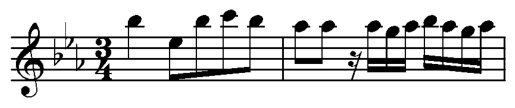

labels.shape: torch.Size([20])


In [4]:
visualize_sample(train_data)

## Train Model

Having loaded the dataset, we can start defining our model. For this, we need to define some hyperparameters that will be necessary for training. Use the following cell to define your own training parameters.

In [5]:
hparams = {
    "batch_size": 3,
    "epochs": 10,
    "early_stop": {
        "patience": 25
    },
    "scheduler": {
        "plateau_patience": 10,
        "plateau_decay": 0.4,
        "threshold": 0.00005,
        "threshold_mode": "rel",
        "mode": "min",
        "cooldown": 0,
        "eps": 1e-8
    },
    "optimizer": {
        "learning_rate": 1e-3,
        "weight_decay": 1e-4
    },
}

Given these model parameters, we can initialize our model. For the Primus dataset we use the `MonophonicModel` that is defined in `monophonic_nn.py`. It is suitable to predict sequences of unknown length (since we don't know in advance how many music symbols are depicted in an image). Note that we primarily focus on monophonic scores, i.e. a single line of music notation.

In [6]:
from networks.monophonic_nn import MonophonicModel
from utils.utils import create_tqdm_bar

model = MonophonicModel(
    hparams=hparams,
    output_size=len(dataset.index_to_vocabulary)
)

Next, we run the training epochs of our model. After each epoch, we run our model on validation data to track the model's performance over time. We use early stopping which means that we terminate training early once the performance gain doesn't improve for several epochs.

In [7]:
def collate_fn(batch):
    """ Custom collate function for DataLoader. """
    # Separate data and labels
    data, labels = zip(*batch)

    # Find the maximum width and height in the batch
    max_width = max([d.shape[2] for d in data])
    max_height = max([d.shape[1] for d in data])

    # Handling data (images)
    padded_data = []
    for d in data:
        # Calculate padding size
        padding_left = (max_width - d.shape[2]) // 2
        padding_right = max_width - d.shape[2] - padding_left
        padding_top = (max_height - d.shape[1]) // 2
        padding_bottom = max_height - d.shape[1] - padding_top

        # Apply padding
        padded = torch.nn.functional.pad(d, (padding_left, padding_right, padding_top, padding_bottom), "constant", 0)
        padded_data.append(padded)

    # Stack all the padded images and labels into tensors
    padded_data = torch.stack(padded_data)

    # Handling labels
    # Find the maximum label length
    max_label_len = max([len(l) for l in labels])

    # Pad labels
    padded_labels = []
    for l in labels:
        # Padding length
        padding_len = max_label_len - len(l)

        # Pad and append
        padded_label = torch.cat((l, torch.full((padding_len,), -1, dtype=torch.long))) # Using -1 as padding token
        padded_labels.append(padded_label)

    # Stack padded labels
    labels = torch.stack(padded_labels)

    return padded_data, labels

In [8]:
def train_model(model, loss_func=torch.nn.CTCLoss(blank=0), epochs=20):

      # obtain model optimizer
      optimizer = model.optimizer

      # decrease lr of optimizer when reaching a plateau
      scheduler_hparams = hparams["scheduler"]
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                  optimizer=optimizer,
                  mode=scheduler_hparams["mode"],
                  patience=scheduler_hparams["plateau_patience"],
                  factor=scheduler_hparams["plateau_decay"],
                  threshold=scheduler_hparams["threshold"],
                  threshold_mode=scheduler_hparams["threshold_mode"],
                  cooldown=scheduler_hparams["cooldown"],
                  eps=scheduler_hparams["eps"],
      )

      # select device for model
      model = model.to(device)

      # initialize early stopping criteria
      stopping_hparams = hparams["early_stop"]
      best_loss, best_model, best_optimizer = -1, None, None
      patience, current_patience = stopping_hparams["patience"], stopping_hparams["patience"]

      # run epochs
      for epoch in range(epochs):

          # training for each minibatch
          train_loader = torch.utils.data.DataLoader(train_data, batch_size=hparams["batch_size"], shuffle=False, collate_fn=collate_fn)
          train_loop = create_tqdm_bar(train_loader, desc=f"Training Epoch [{epoch + 1}/{epochs}]")
          train_loss, val_loss = 0, 0

          for train_iteration, batch in train_loop:

              # perform training step
              print("\nAbout to perform training iteration")
              loss = model.training_step(batch, loss_func, device)
              print(f"Training iteration completed! Loss: loss.item()")
              train_loss += loss.item()

              # Update the progress bar.
              train_loop.set_postfix(curr_train_loss = "{:.8f}".format(
                  train_loss / (train_iteration + 1)), val_loss = "{:.8f}".format(val_loss)
              )

          # validation for each minibatch
          val_loader = torch.utils.data.DataLoader(val_data, batch_size=hparams["batch_size"], shuffle=False, collate_fn=collate_fn)
          val_loop = create_tqdm_bar(val_loader, f"Validation Epoch [{epoch + 1}/{epochs}]")
          val_loss = 0

          for val_iteration, batch in val_loop:

              # perform validation step
              loss = model.validation_step(batch, loss_func, device)
              val_loss += loss.item()

              # update the progress bar.
              val_loop.set_postfix(val_loss = "{:.8f}".format(val_loss / (val_iteration + 1)))

          # learning rate update for each epoch
          pre_lr = optimizer.param_groups[0]["lr"]
          scheduler.step(val_loss)
          post_lr = optimizer.param_groups[0]['lr']
          if post_lr < pre_lr:
            print("Loading best model due to learning rate decrease.")
            model = best_model.to(device)

          # check for early stopping
          if val_loss < best_loss or best_loss == -1:
              current_patience = patience
              best_loss = val_loss
              best_model = model
              best_optimizer = optimizer.state_dict()
          else:
              current_patience -= 1

              if current_patience == 0:
                  print(f"\n{'===' * 10}\nStopping early at epoch {epoch}\n{'===' * 10}")
                  model.load_state_dict(best_model)
                  optimizer.load_state_dict(best_optimizer)
                  break

          val_loss /= len(val_loader)

      model = best_model.to(device)

In [ ]:
train_model(model, epochs=hparams["epochs"])

Training Epoch [1/10]:   0%|                                                                                                    | 0/2 [00:00<?, ?it/s]


About to perform training iteration
[...] Training Step
[...] Loading data
[...] Making predictions
	[...] conv_block
	[...] reshape
	[...] recurrent_block
	[...] output_block
[...] Calculating loss
[...] Backpropagating with loss 22.033899307250977


## Check Model Performance

## Save Model